In [1]:

from random import seed, shuffle
from scipy.stats import multivariate_normal 
import sys
sys.path.insert(1, '/home/preuer/OneDrive/Studium/Master/Semester/Sem_4/Master Thesis/Experiments/tools') # so i can import tools
from  gen_synth_data import *
from plot_helper import *
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Configuration to make plots nicer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Generation

In [3]:
n_samples = 1000
disc_factor = np.pi / 4.0
plot_data = True

In [4]:
def sens_feat(phi, X):
    rotation_matrix = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
    return X @ rotation_matrix

def cos_sim(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

def gen_gaussian(mean_in, cov_in, class_label):
    
    nv = multivariate_normal(mean = mean_in, cov = cov_in)
    X = nv.rvs(n_samples)
    y = np.ones(n_samples, dtype=float) * class_label
    return nv,X,y

In [5]:
SEED = 1122334456
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)



NameError: name 'x_control' is not defined

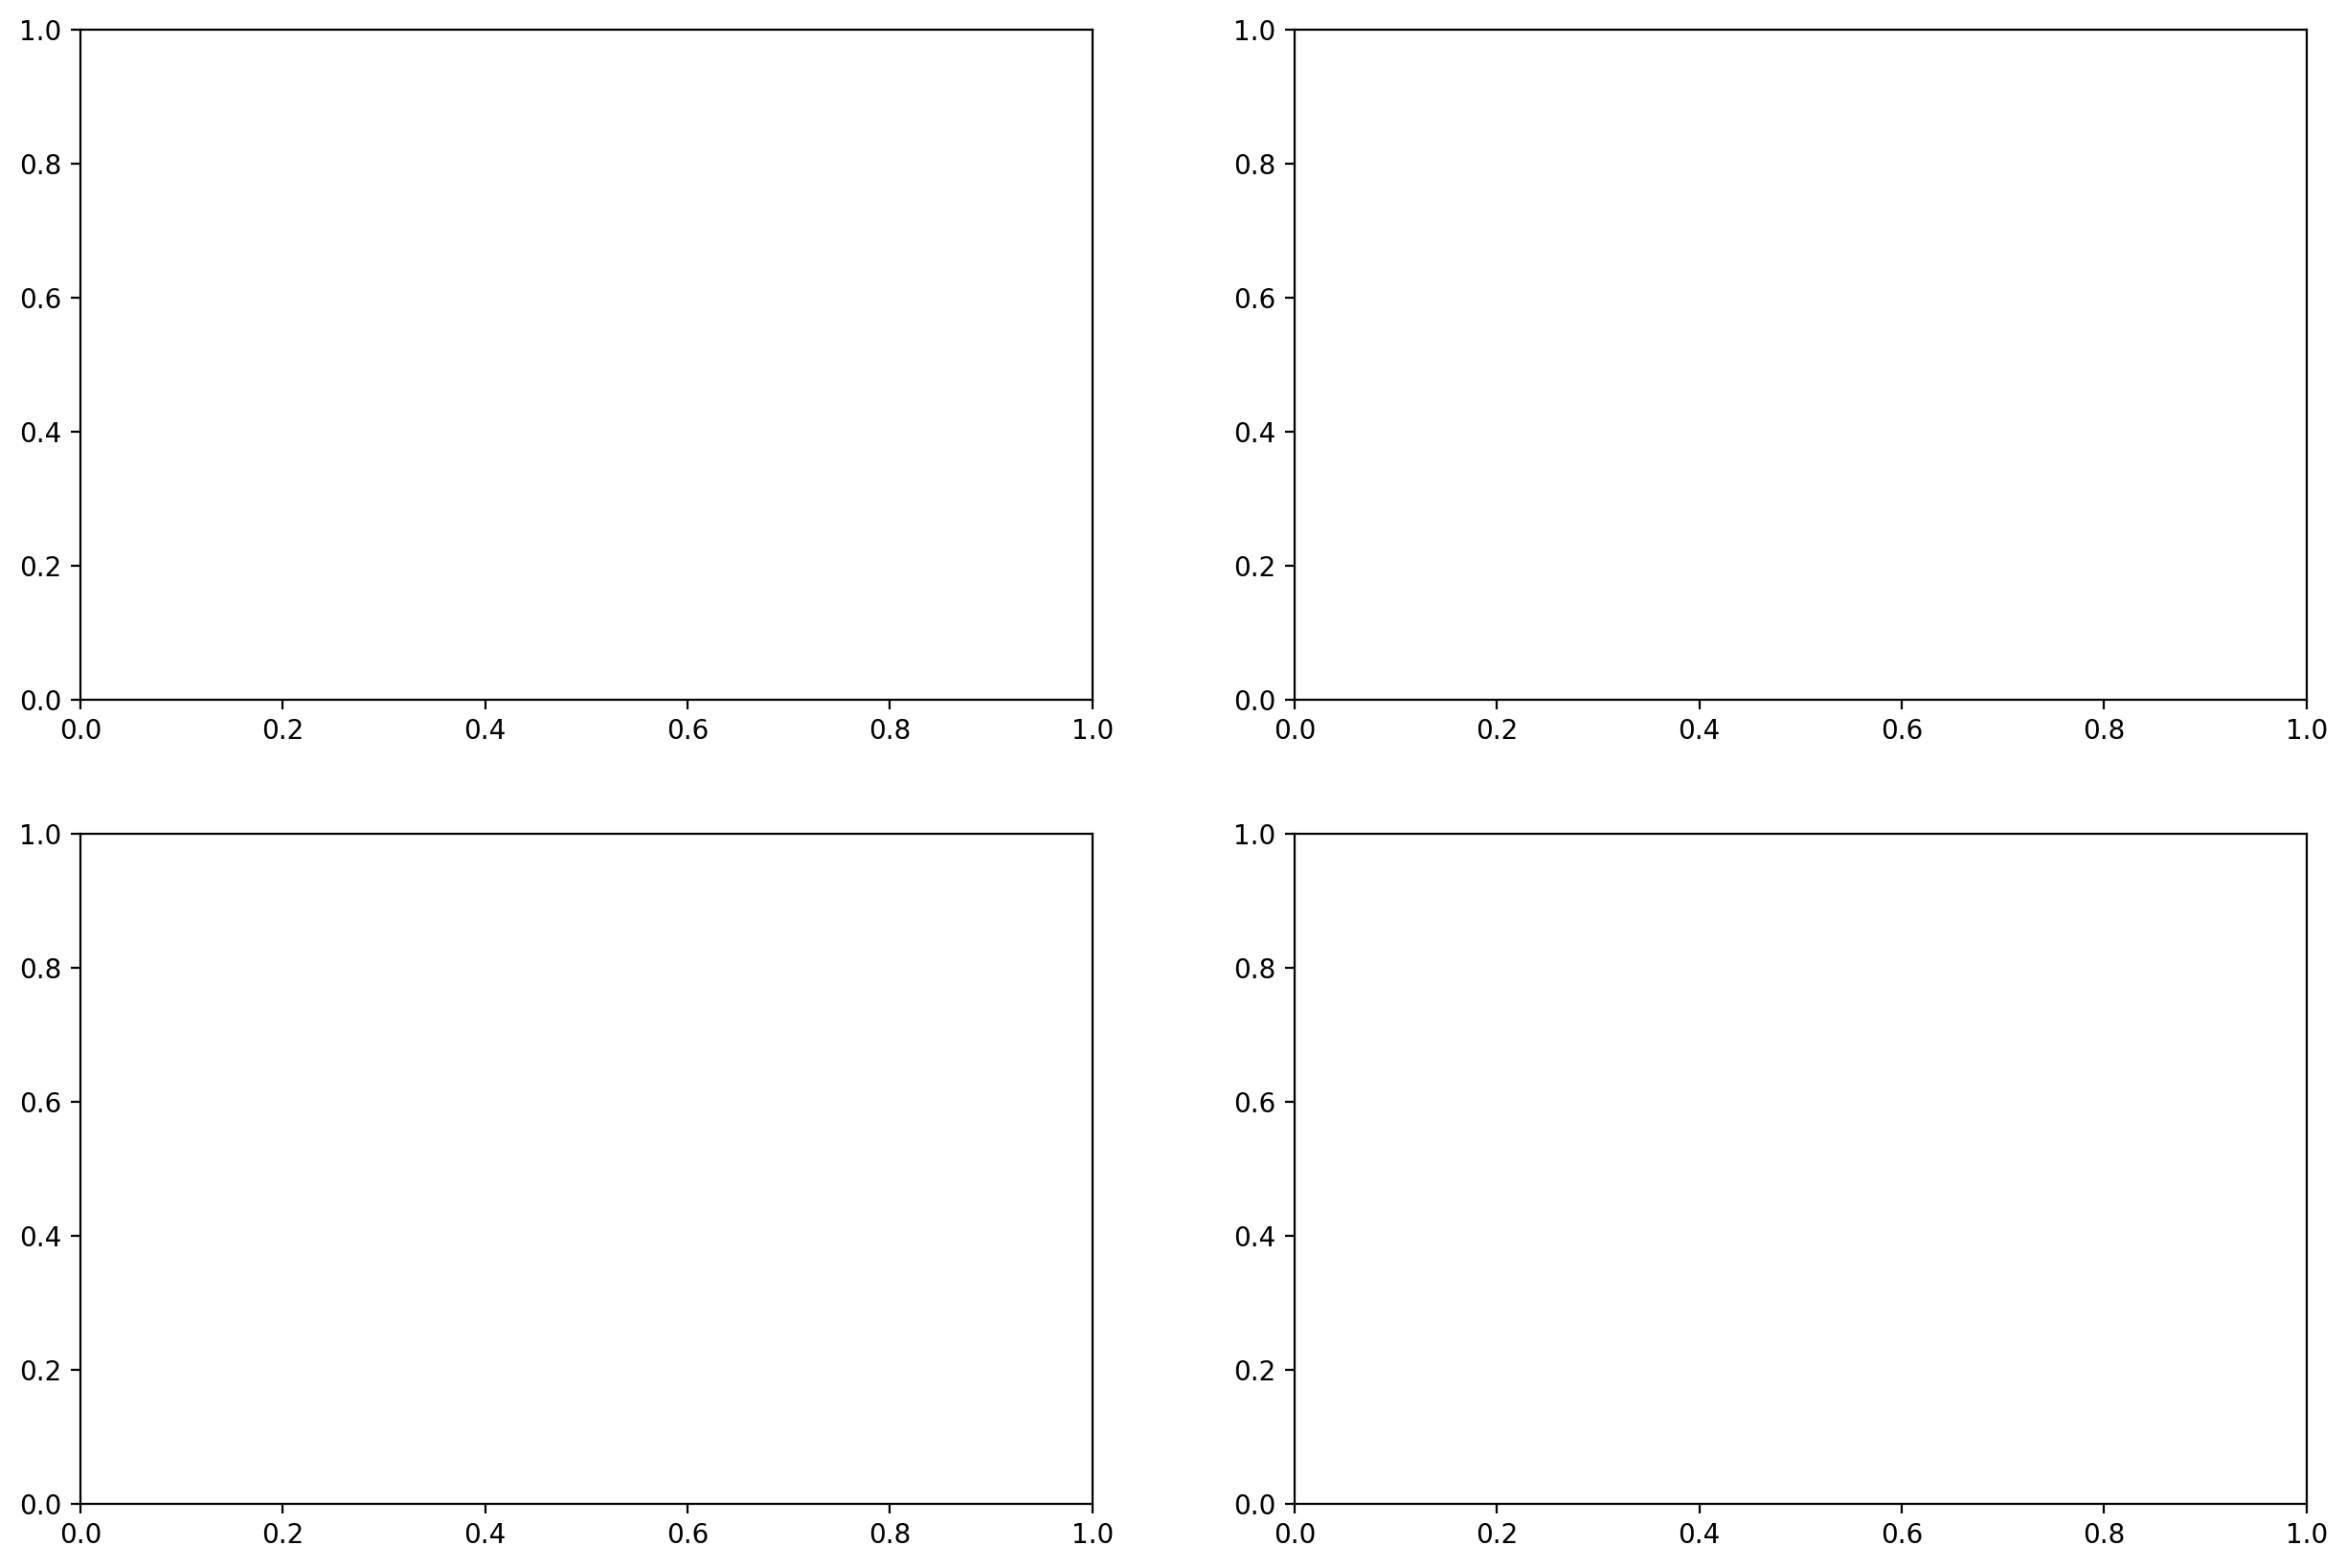

In [6]:
#p(x|y=1)
mean1 = [2, 2]
covar1 = [[5, 1], 
          [1, 5]]

#p(x|y=-1)
mean2 = [-2, -2]
covar2 = [[10, 1], 
          [1, 3]]

nv1, Xp, Yp = gen_gaussian(mean1, covar1, 1)
nv2, Xn, Yn = gen_gaussian(mean2, covar2, -1)

X = np.vstack((Xp, Xn))
Y = np.hstack((Yp, Yn))

np.random.seed(SEED)
perm = np.random.RandomState(seed=SEED).permutation(X.shape[0])
X = X[perm]
Y= Y[perm]

""" Generate the sensitive feature here """
Y_sen = [] # this array holds the sensitive feature value

disc_factors = [0, np.pi / 6.0, np.pi / 3.0, np.pi / 2.0]  # Different disc_factor values

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for f, disc_factor in enumerate(disc_factors):
    X_Prime = sens_feat(disc_factor, X)
    
    for i in range (0, len(X)-1):
        x = X_Prime[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)

        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s

        r = np.random.uniform() # generate a random number from 0 to 1

        if r < p1: # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    Y_sen = np.array(Y_sen)

    """ Show the data """
    if plot_data:
        if f == 0:
            i = j = 0
        elif f == 1:
            i = 0
            j = 1
        elif f == 2:
            i = 1
            j = 0
        elif f == 3:
            i = j = 1
            
        num_to_draw = 400 # we will only draw a small number of points to avoid clutter
        x_draw = X[:num_to_draw]
        y_draw = Y[:num_to_draw]
        y_sen_draw = Y_sen[:num_to_draw]

        X_s_0 = x_draw[y_sen_draw == 0.0]   #samples where Y hat is 0 -> females
        X_s_1 = x_draw[y_sen_draw == 1.0]   #samples where Y hat is 1 -> males
        y_s_0 = y_draw[y_sen_draw == 0.0]   #sentive labels ..
        y_s_1 = y_draw[y_sen_draw == 1.0]
        
        ax[i,j].scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.4, label= f"Prot. +ve disc_fac: {disc_factor:.2f}")
        ax[i,j].scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.4, label = f"Prot. -ve disc_fac: {disc_factor:.2f}")
        ax[i,j].scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='lightgreen', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
        ax[i,j].scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='orange', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")


        ax[i,j].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
        ax[i,j].tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        ax[i,j].legend(loc=2, fontsize=10)
        ax[i,j].set_xlim((-15,10))
        ax[i,j].set_ylim((-10,15))

    x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    x_control = [] # reset x_control for the next iteration

plt.savefig(f"img/data_{disc_factor}.png")
plt.show()


### 30.08.24 Examine eq 15 for Demographic Parity Bobs (BCP)

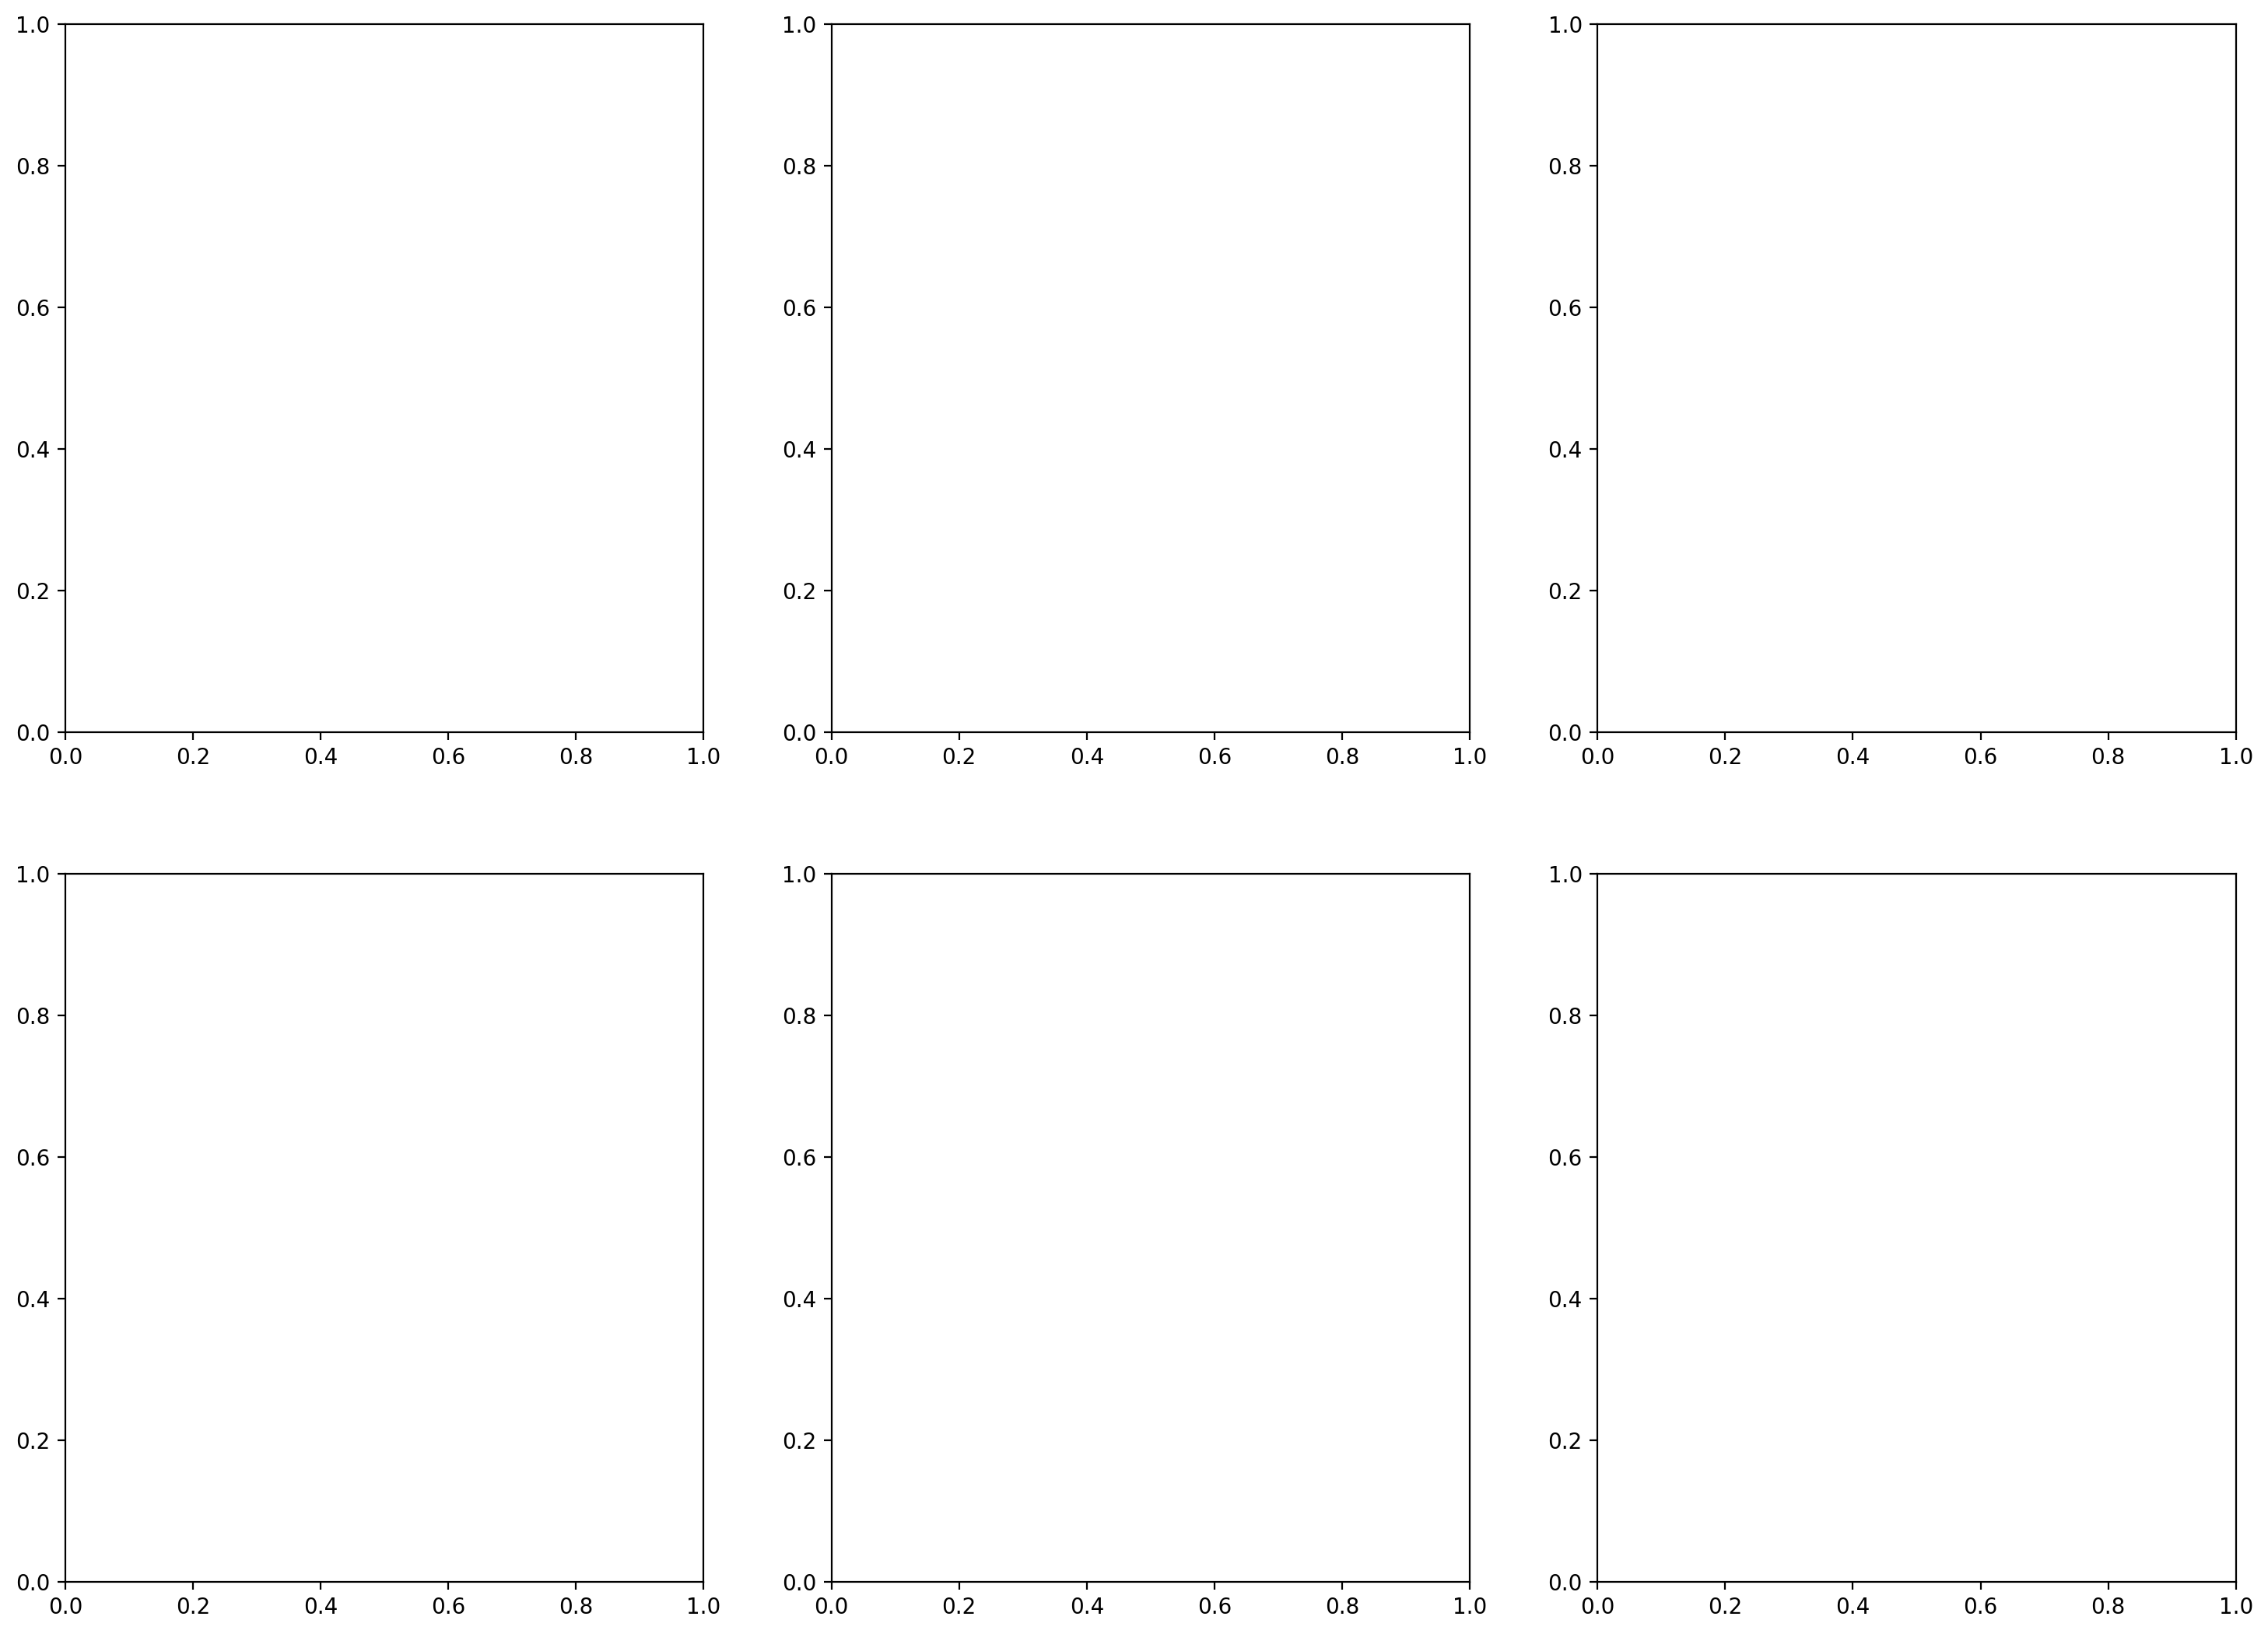

In [7]:
np.random.seed(0)  # Set seed for reproducibility
flip_prob = 0.8  # Probability of flipping each value
disc_factor = [0]

for df in disc_factor:
    X, Y, Y_sen = generate_synthetic_data(False, 1000, disc_factor=df)
    
    #Here we corrupt the labels
    mask = np.random.rand(Y.shape[0]) < flip_prob
    Y_corrupted =  np.where(mask, -Y, Y)            # Y is -1 or 1
    Y_sen_corrupted = np.where(mask, 1 - Y_sen, Y_sen) #Y_sen is 0 or 1!!!

    p_reg, p_reg_cor, f_reg, f_reg_cor = LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()
    p_reg.fit(X, Y)
    p_reg_cor.fit(X, Y_corrupted)
    f_reg.fit(X, Y_sen)
    f_reg_cor.fit(X, Y_sen_corrupted)

    #We only draw a small number of points to avoid clutter in plot
    num_to_draw = 200
    x_draw = X[:num_to_draw]
    y_draw = Y[:num_to_draw]
    Y_sen_draw = Y_sen[:num_to_draw]

    X_s_0 = x_draw[Y_sen_draw == 0.0]
    X_s_1 = x_draw[Y_sen_draw == 1.0]
    y_s_0 = y_draw[Y_sen_draw == 0.0]
    y_s_1 = y_draw[Y_sen_draw == 1.0]

    # Create a mesh grid of points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Predict probabilities for each point on the grid
    Y_pred_p = p_reg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    Y_pred_p_cor = p_reg_cor.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    Y_pred_f = f_reg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    Y_pred_f_cor = f_reg_cor.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    #Plotting
    fig, axs = plt.subplots(2, 3, figsize=(18, 13))
    axs = axs.flatten()

    #Eq 15
    for i, a in enumerate(np.linspace(0, 1, 6)):
        s = a*Y_pred_p_cor + (1-a)*Y_pred_f_cor
        
        #subplot_reg_corr(fig, axs[i], Y_pred_p, Y_pred_p_cor, Y_pred_f,Y_pred_f_cor, Y_pred_all, xx, yy, X_s_0, y_s_0, X_s_1, y_s_1, disc_factor=df, a=a, legend_outside=True)
    #plt.savefig(f"img/fairness_aware_regression_synthetic_data_rnd_label_noise_6/fairness_aware_regression_df_{df:.2f}_label_noise_{flip_prob}.png")

## Experiment: 2LR Plugin-Approach and how label noise affects tradeoff

In [8]:
np.random.seed(0)  # Set seed for reproducibility
flip_prob = 0.14  # Probability of flipping each value
disc_factor = [0.5]

for df in disc_factor:
    X, Y, Y_sen = generate_synthetic_data(False, n_samples=2000, disc_factor=df)    #n_samples are per gaussian distributions, we have two hence total_n = 2*n_samples
    print(Y[:10])
    #Here we corrupt the labels
    mask = np.random.rand(Y.shape[0]) < flip_prob
    Y_corrupted =  np.where(mask, -Y, Y)            # Y is -1 or 1
    Y_sen_corrupted = np.where(mask, 1 - Y_sen, Y_sen) #Y_sen is 0 or 1!!!

    #Devide Set into training and test set
    split_index = int(0.8 * len(X))

    # Split the points into training and testing sets
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]
    Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]
    Y_corr_train, Y_corr_test = Y_corrupted[:split_index], Y_corrupted[split_index:]
    Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]
    

    p_reg, p_reg_cor, f_reg, f_reg_cor = LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()
    p_reg.fit(X_train, Y_train)
    p_reg_cor.fit(X_train, Y_corr_train)
    f_reg.fit(X_train, Y_sen_train)
    f_reg_cor.fit(X_train, Y_sen_corr_train)


    # Create a mesh grid of points - needed to draw decision boundry
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    #plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', marker='o', linewidths=0.5, s=25, alpha=0.8) 

[1. 1. 1. 0. 1. 1. 1. 1. 0. 0.]


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store BER and MD for each lambda value
lmd_values = np.linspace(0, 2, 500)  # 100 values from 0 to 4
BER_list = []
MD_list = []

# Constants c and c_bar
c, c_bar = 0.5, 0.5

# Loop over different values of lambda
for lmd in lmd_values:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)

    # Compute confusion matrix components
    TP = np.sum((Y_pred == 1) & (Y_test == 1))  # True Positives
    TN = np.sum((Y_pred == 0) & (Y_test == 0))  # True Negatives
    FP = np.sum((Y_pred == 1) & (Y_test == 0))  # False Positives
    FN = np.sum((Y_pred == 0) & (Y_test == 1))  # False Negatives

    # Calculate FPR, FNR, BER and MD
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) != 0 else 0
    BER = (FPR + FNR) / 2
    # Append BER and MD values to lists
    BER_list.append(BER)
    
    # Compute confusion matrix components
    TP = np.sum((Y_pred == 1) & (Y_sen_test == 1))  # True Positives
    TN = np.sum((Y_pred == 0) & (Y_sen_test == 0))  # True Negatives
    FP = np.sum((Y_pred == 1) & (Y_sen_test == 0))  # False Positives
    FN = np.sum((Y_pred == 0) & (Y_sen_test == 1))  # False Negatives

    # Calculate FPR, FNR, BER and MD
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) != 0 else 0
    MD = FPR + FNR - 1
    MD_list.append(MD)

def transform_x(x):
    return (x + 1)  # This shifts the range [-1, 0] to [0, 1]

# Apply the transformation to the mean difference values
transformed_MD_list = [transform_x(x) for x in MD_list]



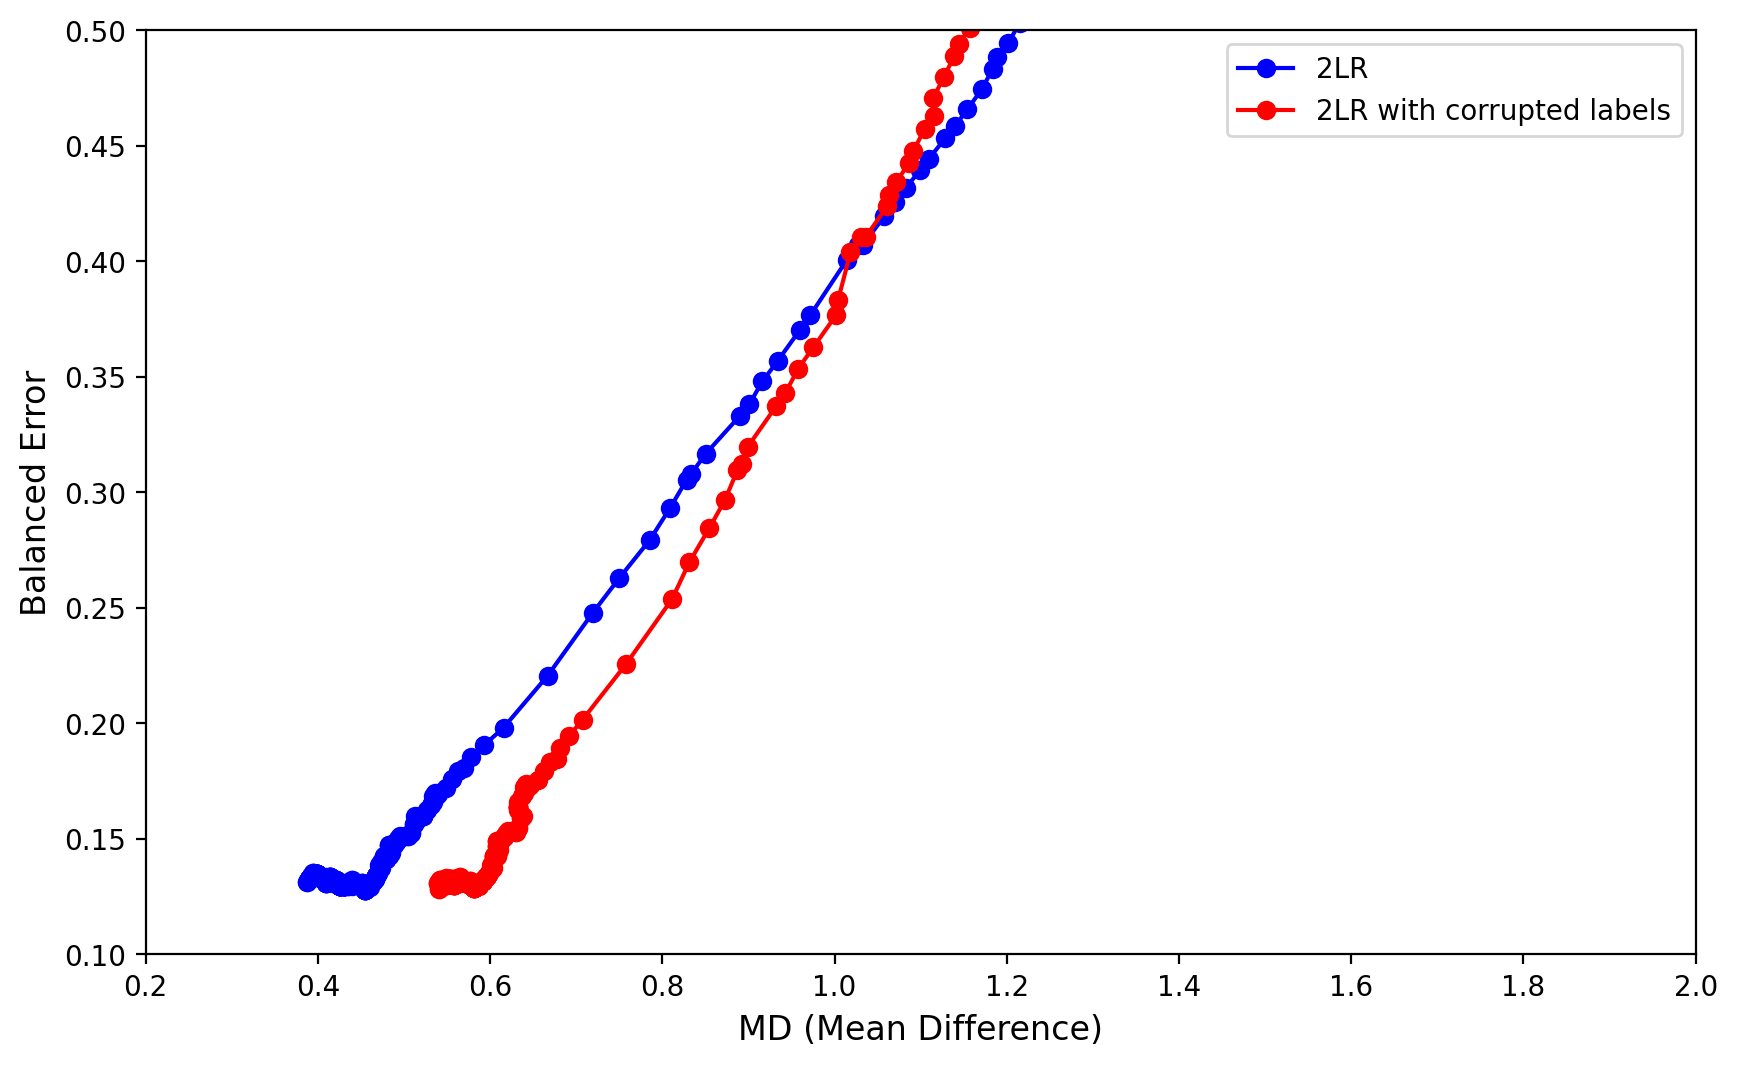

In [13]:
import numpy as np
import matplotlib.pyplot as plt

BER_list_corr = []
MD_list_corr = []

# Constants c and c_bar
c, c_bar = 0.5, 0.5

# Loop over different values of lambda
for lmd in lmd_values:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)

    # Compute confusion matrix components
    TP = np.sum((Y_pred == 1) & (Y_corr_test == 1))  # True Positives
    TN = np.sum((Y_pred == 0) & (Y_corr_test == 0))  # True Negatives
    FP = np.sum((Y_pred == 1) & (Y_corr_test == 0))  # False Positives
    FN = np.sum((Y_pred == 0) & (Y_corr_test == 1))  # False Negatives

    # Calculate FPR, FNR, BER and MD
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) != 0 else 0
    BER = (FPR + FNR) / 2
    # Append BER and MD values to lists
    BER_list_corr.append(BER)
    
    # Compute confusion matrix components
    TP = np.sum((Y_pred == 1) & (Y_sen_corr_test == 1))  # True Positives
    TN = np.sum((Y_pred == 0) & (Y_sen_corr_test == 0))  # True Negatives
    FP = np.sum((Y_pred == 1) & (Y_sen_corr_test == 0))  # False Positives
    FN = np.sum((Y_pred == 0) & (Y_sen_corr_test == 1))  # False Negatives

    # Calculate FPR, FNR, BER and MD
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) != 0 else 0

    MD = FPR + FNR - 1
    MD_list_corr.append(MD)

def transform_x(x):
    return (x + 1)  # This shifts the range [-1, 0] to [0, 1]

# Apply the transformation to the mean difference values
transformed_MD_list_corr = [transform_x(x) for x in MD_list_corr]

# Plot BER (y-axis) against MD (x-axis)
plt.figure(figsize=(10, 6))
# Plot BER vs MD
plt.plot(transformed_MD_list, BER_list, label="2LR", color="blue", marker='o')
plt.plot(transformed_MD_list_corr, BER_list_corr, label="2LR with corrupted labels", color="red", marker='o')

# Labels and Title
plt.xlabel("MD (Mean Difference)", fontsize=12)
plt.ylabel("Balanced Error", fontsize=12)

plt.xlim(0.2, 2)
plt.ylim(0.1, 0.5)

plt.legend()
plt.show()


In [30]:
n=4
print(X[n])
print(Y[n])

[0.89751781 6.05295868]
1.0


In [25]:
p_reg.predict_proba([[0,0.5]])

array([[0.39346488, 0.60653512]])